# Predicting Anxiety
---

Import libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

---

## Import cleaned data parquet file

Import the cleaned data that was the output of the 1st notebook

In [2]:
df = pd.read_parquet("../data/mental_health_social_media_dataset_cleaned.parquet")

---
## Select Features

In [4]:
# List numeric columns
numeric_features = [
    "age",
    "daily_screen_time_min",
    "social_media_time_min",
    "physical_activity_min",
    "interaction_negative_ratio",
    "stress_level",
    "mood_level",
    "sleep_hours"
]

# List categorical columns
categorical_features = ["gender", "platform", "mental_state"]

# List all features
features = numeric_features + categorical_features

# List target variable
target = "anxiety_level"

# Select features and target variable
data = df[features + [target]].copy()

---
## Train/Test split the data

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target],
    test_size=0.2, random_state=42
)

---
## Build the pipeline

In [6]:
# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LinearRegression())
])

---
## Fit pipeline

In [7]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


---
## Evaluate the results

In [8]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

MAE: 0.19346629544163954
RMSE: 0.24307704472603994
R²: 0.9115467013683537


MAE ≈ 0.19 - On average, the model is off by less than 0.2 points on a 1–10 anxiety scale.

RMSE ≈ 0.24 - Most predictions are within + or - 0.24 points of the true value.

R² ≈ 0.91 - The model explains 91% of the variation in anxiety levels.


Create scatter chart to compare actaul with predicted:

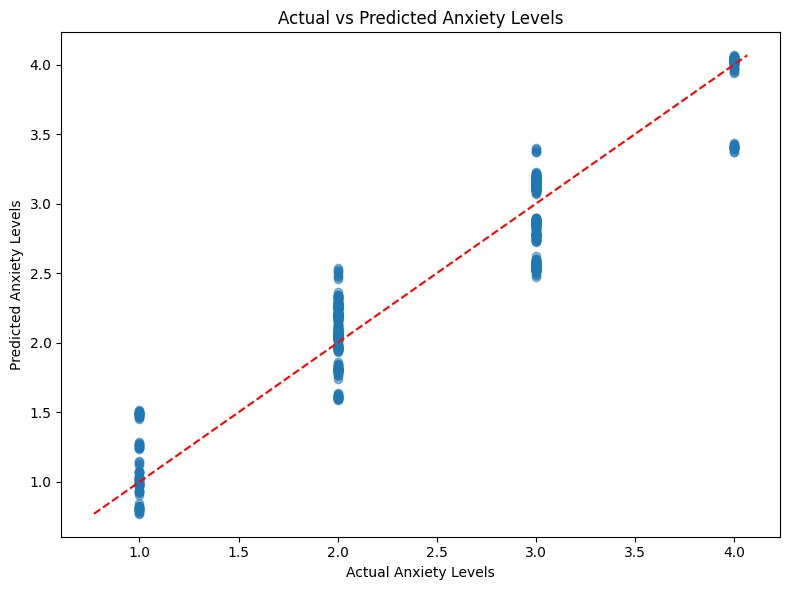

In [9]:
fig = plt.figure(figsize=(8, 6))

# Scatter plot of actual vs predicted anxiety levels
plt.scatter(y_test, y_pred, alpha=0.5)

# Add labels and title
plt.xlabel("Actual Anxiety Levels")
plt.ylabel("Predicted Anxiety Levels")
plt.title("Actual vs Predicted Anxiety Levels")

# Add a diagonal line for reference
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--")

# Show and save the plot
plt.tight_layout()
plt.savefig('../charts/predicting_anxiety_level_linear_regression_scatter.png')
plt.show()

What the plot shows:
- Points cluster tightly around the ideal red diagonal line.
- As anxiety increases, the predicted values increase in a smooth, linear way.
- There's a bit more vertical spread around each group compared to the stress model.
- No curved patterns or systematic under/over-prediction is visible.


Add a residual chart:

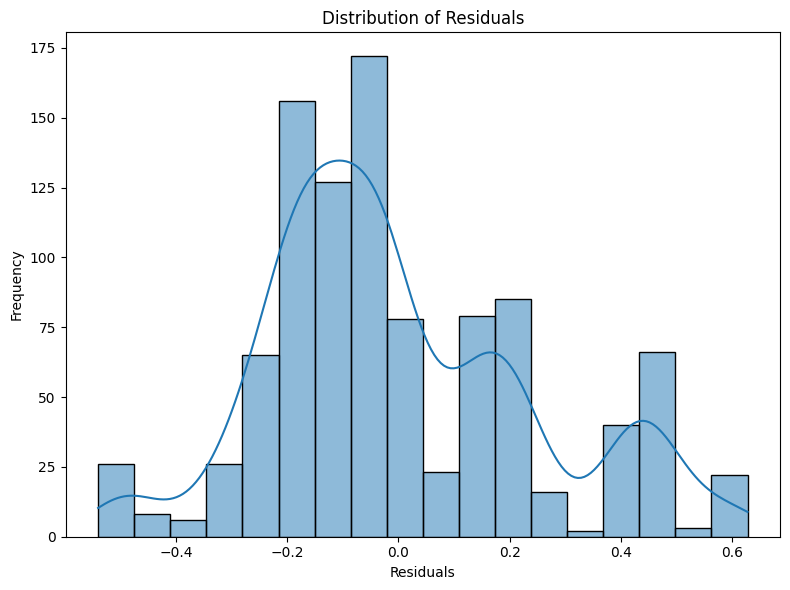

In [10]:
# Calculate residuals
residuals = y_test - y_pred

# Plot the distribution of residuals
plt.figure(figsize=(8, 6))

# Histogram of residuals
sns.histplot(residuals, kde=True)

# Add labels and title
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()

# Show and save the plot
plt.savefig('../charts/predicting_anxiety_level_linear_regression_residuals.png')
plt.show()

The model’s errors are small and centred around zero, but have more natural variability, which reflects the fact that anxiety is harder to predict than sleep or stress in this dataset. Slight skewness is visible.

---
## Save the model

In [11]:
# save the model
joblib.dump(pipeline, '../models/predicting_anxiety_level_linear_regression_model.pkl')

['../models/predicting_anxiety_level_linear_regression_model.pkl']

---
## Run the model on unseen data

I am going to use the persona data created on the cluster notebook to make test predictions.

In [12]:
# laod the persona data
cluster_profiles = pd.read_parquet("../data/cluster_profiles.parquet")

# Prepare input data for prediction
persona_input = cluster_profiles.drop(columns=["anxiety_level"])

# Make predictions for each persona
preds = pipeline.predict(persona_input)

# Combine predictions with cluster profiles
results = cluster_profiles.copy()
results["model_prediction"] = preds

# Display the results
results

,age,daily_screen_time_min,social_media_time_min,sleep_hours,physical_activity_min,interaction_negative_ratio,stress_level,mood_level,anxiety_level,gender,platform,mental_state,model_prediction
cluster,,,,,,,,,,,,,
0,24.568182,423.176573,105.818182,6.882517,17.681818,0.112762,6.624126,6.202797,1.797203,Male,WhatsApp,Stressed,1.830596
1,25.189744,411.379487,149.000000,6.942949,18.857692,0.428205,7.170513,5.747436,2.252564,Female,Facebook,Stressed,2.319081
2,24.178295,422.108527,232.156977,6.888953,17.790698,0.328327,7.674419,5.325581,3.000000,Female,Snapchat,Stressed,2.967334
3,23.417417,435.710961,224.520270,6.820420,16.427177,0.266892,7.759760,5.240240,2.995495,Female,YouTube,Stressed,2.977956
4,50.829574,194.558897,66.328321,8.030576,40.546366,0.000000,5.000000,7.000000,1.000000,Female,Facebook,Healthy,1.004300
5,45.391153,228.046566,121.833527,7.861467,37.190920,0.311021,6.112922,5.989523,2.053551,Male,TikTok,Stressed,2.364592
6,24.166052,425.575646,276.634686,6.871402,17.450185,0.427429,8.512915,4.487085,3.811808,Male,TikTok,Stressed,3.722760


View just the anxiety columns:

In [13]:
# display just anxiety level and model prediction
results[["anxiety_level", "model_prediction"]]

,anxiety_level,model_prediction
cluster,,
0,1.797203,1.830596
1,2.252564,2.319081
2,3.000000,2.967334
3,2.995495,2.977956
4,1.000000,1.004300
5,2.053551,2.364592
6,3.811808,3.722760


The anxiety model also generalised well when tested on the persona clusters. 

For each persona, the predicted anxiety level was close to the cluster’s true average, typically within a few hundredths or tenths of a point. The relative pattern across personas was preserved, low-anxiety clusters were predicted as low, and high-anxiety clusters remained high. Although predictions showed slightly more variation than the sleep or stress models, this is expected given that anxiety is naturally more variable in the dataset. 

Overall, the model behaves consistently and captures the key emotional patterns in anxiety very effectively.

---
## Conclusion

The anxiety prediction model performs strongly, achieving low error rates and explaining over 91% of the variation in anxiety levels.

While anxiety is naturally more variable and harder to predict than sleep or stress, the model still captures the main behavioural and emotional patterns that drive it. 

The residuals show small, balanced errors, and the actual-vs-predicted plot follows a clean upward trend with only modest scatter.

When applied to the persona clusters, the model’s predictions closely matched the true anxiety profiles, confirming that it generalises well and remains consistent with the patterns observed earlier in the analysis. 

Overall, the model provides reliable and meaningful predictions within the structured nature of the dataset.